# Appendix A - Classes and Simulation

## Appendix A.1 - Simulation Implementation

In [ ]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sts

In [ ]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.

    The `now` attribute contains the time at which the last event was run.
    '''

    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run

    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))

    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)

    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)

    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')

    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'{event.timestamp}: {event.function.__name__}')

In [ ]:
class Queue:

    '''
    Class:
        Represents a single queue at the airport.

    Attributes:
        service_distribution (continuous): Distribution of service times for travelers in the queue.
        additional_screening_distribution (continuous): Distribution of additional screening times.
        num (int): Queue number.
        people_in_queue (int): Number of people currently in the queue.
        people_being_served (int): Number of people currently being served.
        additional_screening_in_progress (bool): Status of additional screening in a queue.
        entry_times (list): Timestamps when individuals enter the queue.
        start_service_times (list): Timestamps when service start for individuals.
        length (list): Tracks constant update in the length of the queue over time.
    '''

    def __init__(self, service_distribution, additional_screening_distribution, num):
        '''Initialize the Queue with given parameters.'''

        self.service_distribution = service_distribution
        self.additional_screening_distribution = additional_screening_distribution
        self.num = num
        self.people_in_queue = 0
        self.people_being_served = 0
        self.additional_screening_in_progress = False

        self.entry_times = []
        self.start_service_times = []
        self.length = []

    def add_person(self, schedule, airport):
        '''Add a person to the queue and, if the criteria is satisfied, start serving them.'''

        self.entry_times.append(schedule.now)
        self.people_in_queue += 1
        self.length.append(self.people_in_queue) # Keep track of how the length of the queue changes over time

        # If no one is currently being served, and no additional screening is in progress, start service
        if self.people_being_served < 1 and self.additional_screening_in_progress == False and self not in airport.additional_screening_queue:
            schedule.add_event_after(0, self.start_serving_person, airport)

    def start_serving_person(self, schedule, airport):
        '''Start the service for a person in the queue.'''

        self.start_service_times.append(schedule.now)
        self.people_in_queue -= 1
        self.people_being_served += 1
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_person, airport)

    def finish_serving_person(self, schedule, airport):
        '''Complete the service for a person and potentially send them for additional screening.'''

        self.people_being_served -= 1
        self.length.append(self.people_in_queue) #keep track of how the length of the queue changes

        # Determine if this person needs additional screening
        if np.random.rand() <= 0.05:  # 5% chance of additional screening
            airport.request_additional_screening(schedule, self)

        # If there are people in the queue, and if there is no additional screening going on, serve the next one
        elif self.people_in_queue > 0 and self.additional_screening_in_progress == False and self not in airport.additional_screening_queue:
            schedule.add_event_after(0, self.start_serving_person, airport)

class Airport:

    '''
    Class:
    Represent the airport system with multiple queues and additional screening processes.

    Attributes:
        queues (list): List of Queue objects representing all the queues in the airport.
        arrival_distribution (continuous): Distribution of arrival times.
        senior_officer_free (bool): Whether the senior officer is available to serve additional screenings.
        additional_screening_queue (list): A heap-based priority queue for additional screenings.
        total_customers (int): Total customers in the system until specified time.
        additional_screened (int): Total customers that underwent additional screening.
    '''

    def __init__(self, arrival_distribution, service_distribution, additional_screening_distribution, no_of_queues):
        '''Initialize the airport system with the given parameters and attributes.'''

        self.queues = [Queue(service_distribution, additional_screening_distribution, i) for i in range(no_of_queues)]
        self.arrival_distribution = arrival_distribution
        self.senior_officer_free = True
        self.additional_screening_queue = []

        self.total_customers = 0
        self.additional_screened = 0

    def find_shortest_queue(self):
        '''Find and return the shortest queue.'''

        return min(self.queues, key=lambda queue: queue.people_in_queue)

    def add_person(self, schedule):
        '''Add a traveler to the shortest queue and schedule the next traveler's arrival.'''

        self.total_customers += 1
        self.find_shortest_queue().add_person(schedule, self) #  This add_person is a Queue class method
        schedule.add_event_after(self.arrival_distribution.rvs(), self.add_person)

    def request_additional_screening(self, schedule, queue):
        '''Request additional screening for a person.'''

        self.additional_screened += 1
        heapq.heappush(self.additional_screening_queue, (schedule.now, queue))

        # Start the additional screening if senior officer is free
        if self.senior_officer_free == True and queue.additional_screening_in_progress == False:
            self.start_additional_screening(schedule)

    def start_additional_screening(self, schedule):
        '''Start the additional screening process.'''

        _, queue = heapq.heappop(self.additional_screening_queue) # discard timestamp, keep the queue reference
        self.senior_officer_free = False
        queue.additional_screening_in_progress = True
        screening_duration = queue.additional_screening_distribution.rvs()
        schedule.add_event_after(screening_duration, self.finish_additional_screening, queue)

    def finish_additional_screening(self, schedule, queue):
        '''Finish the additional screening and potentially start screening for the next person in line.'''

        self.senior_officer_free = True
        queue.additional_screening_in_progress = False

        # If there are still scheduled additional screenings, keep serving them
        if len(self.additional_screening_queue) > 0:
            self.start_additional_screening(schedule)
        elif queue.people_in_queue > 0:
            queue.start_serving_person(schedule, self)

    def run(self, schedule):
        '''Start the simulation by adding the first person.'''

        schedule.add_event_after(self.arrival_distribution.rvs(), self.add_person)

In [ ]:
def run_simulation(arrival_distribution, service_distribution,
                   additional_screening_distribution, no_of_queues, run_until):

    '''
    Run a simulation for an airport system.

    Parameters:
    - arrival_distribution (distribution): Distribution for the arrival of travelers at the airport.
    - service_distribution (distribution): Distribution for the service time for each traveler.
    - additional_screening_distribution (distribution): Distribution for the time taken for additional screenings.
    - no_of_queues (int): Number of queues in the airport.
    - run_until (float): Simulation run time.

    Returns:
    - Airport: An instance of the Airport class after the simulation has run for the specified time.
    '''

    schedule = Schedule()
    airport = Airport(arrival_distribution, service_distribution, additional_screening_distribution, no_of_queues)
    airport.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return airport

# Appendix B - Tests, Experiments and Visualizations

## Appendix B.1 - Test Cases

#### Test Case 1: The additional screening mechanism is correctly working, as showcased by the experimental additional screening rate.

In [ ]:
# Parameters

lambd = 10 # arrival rate, travelers per minute
a = 0 # lower-bound for truncated normal distribution
b = np.inf # upper-bound for truncated normal distribution
mu_1 = 0.5 # mean of trunc. normal distribution for service time distribution, minutes
sigma_1 = 1/6 # std. dev. of trunc. normal distribution for service time distribution, minutes
mu_2 = 2 # mean of trunc. normal distribution for additional screening time distribution, minutes
sigma_2 = 2 # std. dev. of trunc. normal distribution for additional screening time distribution, minutes

arrival_distribution = sts.expon(scale=1/lambd)
service_distribution = sts.truncnorm((a-mu_1)/sigma_1, b, loc = mu_1, scale = sigma_1)
additional_screening_distribution = sts.truncnorm((a-mu_2)/sigma_2, b, loc = mu_2, scale = sigma_2)

# Variables

no_of_queues = 10
run_until = 160*60
trials = 1000 #for experiments

In [ ]:
# Running the simulation 1000 times

airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)

total_customers = []
total_additional_screened = []

for trial in range(trials):
    total_customers.append(airport.total_customers)
    total_additional_screened.append(airport.additional_screened)

print(f'Total customers served over {trials} trials: {np.sum(total_customers)/trials}')
print(f'Additional customers served over {trials} trials: {np.sum(total_additional_screened)/trials}')
print(f'Additional screening request rate: {(np.sum(total_additional_screened)/trials)/(np.sum(total_customers)/trials)}')

Total customers served over 1000 trials: 96386.0
Additional customers served over 1000 trials: 4560.0
Additional screening request rate: 0.047309775278567424


In the final state, the average queue length in the system is 363.6


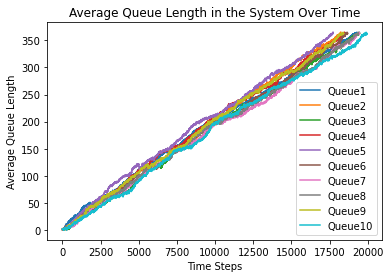

In [ ]:
# Change in Queue Length Over Time

queue_lengths = []

for _ in range(no_of_queues):
    plt.plot(airport.queues[_].length, label = f"Queue{_+1}")
    queue_lengths.append(airport.queues[_].people_in_queue)

print(f'In the final state, the average queue length in the system is {np.sum(queue_lengths)/no_of_queues}')

plt.xlabel("Time Steps")
plt.ylabel("Average Queue Length")
plt.title("Average Queue Length in the System Over Time")
plt.legend()
plt.show()

In the final state, the average queue length in the system is 0.7722


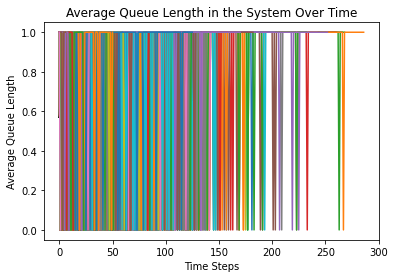

In [ ]:
# Showcasing equilibrium

no_of_queues = 5000
run_until = 160*60

airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)

queue_lengths = []

for _ in range(no_of_queues):
    plt.plot(airport.queues[_].length, label = f"Queue{_+1}")
    queue_lengths.append(airport.queues[_].people_in_queue)

print(f'In the final state, the average queue length in the system is {np.sum(queue_lengths)/no_of_queues}')

plt.xlabel("Time Steps")
plt.ylabel("Average Queue Length")
plt.title("Average Queue Length in the System Over Time")
plt.show()

#### Test Case 2: High Arrival Rate, Low Service Rate: The queue length is expected to increase over time

In [ ]:
lambd = 50 # HIGH arrival rate, travelers per minute
a = 0 # lower-bound for truncated normal distribution
b = np.inf # upper-bound for truncated normal distribution
mu_1 = 1 # mean of trunc. normal distribution for service time distribution, minutes
sigma_1 = 0.5 # std. dev. of trunc. normal distribution for service time distribution, minutes
mu_2 = 2 # mean of trunc. normal distribution for additional screening time distribution, minutes
sigma_2 = 2 # std. dev. of trunc. normal distribution for additional screening time distribution, minutes

arrival_distribution = sts.expon(scale=1/lambd)
service_distribution = sts.truncnorm((a-mu_1)/sigma_1, b, loc = mu_1, scale = sigma_1)
additional_screening_distribution = sts.truncnorm((a-mu_2)/sigma_2, b, loc = mu_2, scale = sigma_2)

# Variables

no_of_queues = 10
run_until = 160*60

airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)

In the final state, the average queue length in the system is 39587.6


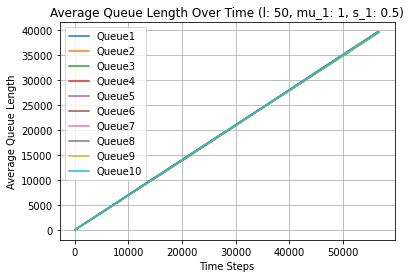

In [ ]:
queue_lengths = []

for _ in range(no_of_queues):
    plt.plot(airport.queues[_].length, label = f"Queue{_+1}")
    queue_lengths.append(airport.queues[_].people_in_queue)

print(f'In the final state, the average queue length in the system is {np.sum(queue_lengths)/no_of_queues}')

plt.xlabel("Time Steps")
plt.ylabel("Average Queue Length")
plt.title(f"Average Queue Length Over Time (l: {lambd}, mu_1: {mu_1}, s_1: {sigma_1})")
plt.grid(True)
plt.legend()
plt.show()

#### Test Case 3: Low Arrival Rate, High Service Rate: The queue length is expected to decrease over time

In [ ]:
lambd = 1 # LOW arrival rate, travelers per minute
a = 0 # lower-bound for truncated normal distribution
b = np.inf # upper-bound for truncated normal distribution
mu_1 = 0.25 # mean of trunc. normal distribution for service time distribution, minutes
sigma_1 = round(1/12, 3) # std. dev. of trunc. normal distribution for service time distribution, minutes
mu_2 = 2 # mean of trunc. normal distribution for additional screening time distribution, minutes
sigma_2 = 2 # std. dev. of trunc. normal distribution for additional screening time distribution, minutes

arrival_distribution = sts.expon(scale=1/lambd)
service_distribution = sts.truncnorm((a-mu_1)/sigma_1, b, loc = mu_1, scale = sigma_1)
additional_screening_distribution = sts.truncnorm((a-mu_2)/sigma_2, b, loc = mu_2, scale = sigma_2)

# Variables

no_of_queues = 10
run_until = 4*60

airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)

In the final state, the average queue length in the system is 0.0


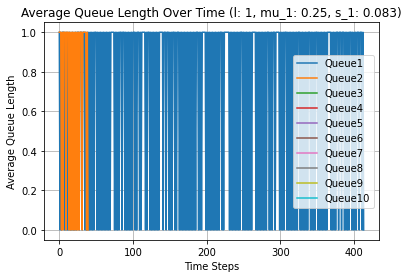

In [ ]:
queue_lengths = []

for _ in range(no_of_queues):
    plt.plot(airport.queues[_].length, label = f"Queue{_+1}")
    queue_lengths.append(airport.queues[_].people_in_queue)

print(f'In the final state, the average queue length in the system is {np.sum(queue_lengths)/no_of_queues}')

plt.xlabel("Time Steps")
plt.ylabel("Average Queue Length")
plt.title(f"Average Queue Length Over Time (l: {lambd}, mu_1: {mu_1}, s_1: {sigma_1})")
plt.grid(True)
plt.legend()
plt.show()

## Appendix B.2 - Visualization of the Code: Implementing "print" statatements.

In [ ]:
# This code is the same as the one under "Classes and Simulations" title, with a few added lines of
# "print statements." Therefore, I didn't repeat the in-line code cells and docstrings to make the code
# look visually more concise.

class QueueVisual:

    def __init__(self, service_distribution, additional_screening_distribution, num):
        self.service_distribution = service_distribution
        self.additional_screening_distribution = additional_screening_distribution
        self.num = num
        self.people_in_queue = 0
        self.people_being_served = 0
        self.additional_screening_in_progress = False

        self.entry_times = []
        self.start_service_times = []
        self.length = []

    def add_person(self, schedule, airport):
        print(f"➕ Adding person to queue {self.num} at ⏳ {schedule.now}.")
        self.entry_times.append(schedule.now)
        self.people_in_queue += 1
        self.length.append(self.people_in_queue) #keep track of how the length of the queue changes
        if self.people_being_served < 1 and self.additional_screening_in_progress == False and self not in airport.additional_screening_queue:
            schedule.add_event_after(0, self.start_serving_person, airport)

    def start_serving_person(self, schedule, airport):
        print(f"✅ Starting service in queue {self.num} at ⏳ {schedule.now}")
        self.start_service_times.append(schedule.now)
        self.people_in_queue -= 1
        self.people_being_served += 1
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_person, airport)

    def finish_serving_person(self, schedule, airport):
        print(f"👋 Finishing service in queue {self.num} at ⏳ {schedule.now}")
        self.people_being_served -= 1
        self.length.append(self.people_in_queue)

        if np.random.rand() <= 0.05:
            airport.request_additional_screening(schedule, self)

        elif self.people_in_queue > 0 and self.additional_screening_in_progress == False and self not in airport.additional_screening_queue:
            schedule.add_event_after(0, self.start_serving_person, airport)

class AirportVisual:

    def __init__(self, arrival_distribution, service_distribution, additional_screening_distribution, no_of_queues):
        self.queues = [QueueVisual(service_distribution, additional_screening_distribution, i) for i in range(no_of_queues)]
        self.arrival_distribution = arrival_distribution
        self.senior_officer_free = True
        self.additional_screening_queue = []

        self.total_customers = 0
        self.additional_screened = 0

    def find_shortest_queue(self):
        return min(self.queues, key=lambda queue: queue.people_in_queue)

    def add_person(self, schedule):
        print("👍 Adding person at ⏳", schedule.now)
        self.total_customers += 1
        self.find_shortest_queue().add_person(schedule, self)
        schedule.add_event_after(self.arrival_distribution.rvs(), self.add_person)

    def request_additional_screening(self, schedule, queue):
        print(f"🥵 Additional screening required in queue {queue.num}")
        self.additional_screened += 1
        heapq.heappush(self.additional_screening_queue, (schedule.now, queue))
        if self.senior_officer_free == True and queue.additional_screening_in_progress == False:
            self.start_additional_screening(schedule)

    def start_additional_screening(self, schedule):
        _, queue = heapq.heappop(self.additional_screening_queue)
        self.senior_officer_free = False
        queue.additional_screening_in_progress = True
        screening_duration = queue.additional_screening_distribution.rvs()
        schedule.add_event_after(screening_duration, self.finish_additional_screening, queue)
        print(f"🤓 Additional screening started in queue {queue.num}")

    def finish_additional_screening(self, schedule, queue):
        print(f"🥱 Additional screening finished in queue {queue.num}")
        self.senior_officer_free = True
        queue.additional_screening_in_progress = False

        if len(self.additional_screening_queue) > 0:
            self.start_additional_screening(schedule)
        elif queue.people_in_queue > 0:
            queue.start_serving_person(schedule, self)

    def run(self, schedule):
        schedule.add_event_after(self.arrival_distribution.rvs(), self.add_person)

In [ ]:
def run_simulation_visual(arrival_distribution, service_distribution,
                   additional_screening_distribution, no_of_queues, run_until):

    '''
    Run a simulation for an airport system.

    Parameters:
    - arrival_distribution (distribution): Distribution for the arrival of travelers at the airport.
    - service_distribution (distribution): Distribution for the service time for each traveler.
    - additional_screening_distribution (distribution): Distribution for the time taken for additional screenings.
    - no_of_queues (int): Number of queues in the airport.
    - run_until (float): Simulation run time.

    Returns:
    - Airport: An instance of the Airport class after the simulation has run for the specified time.
    '''

    schedule = Schedule()
    airport = AirportVisual(arrival_distribution, service_distribution, additional_screening_distribution, no_of_queues)
    airport.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return airport

In [ ]:
lambd = 10 # arrival rate, travelers per minute
a = 0 # lower-bound for truncated normal distribution
b = np.inf # upper-bound for truncated normal distribution
mu_1 = 0.5 # mean of trunc. normal distribution for service time distribution, minutes
sigma_1 = 1/6 # std. dev. of trunc. normal distribution for service time distribution, minutes
mu_2 = 2 # mean of trunc. normal distribution for additional screening time distribution, minutes
sigma_2 = 2 # std. dev. of trunc. normal distribution for additional screening time distribution, minutes

arrival_distribution = sts.expon(scale=1/lambd)
service_distribution = sts.truncnorm((a-mu_1)/sigma_1, b, loc = mu_1, scale = sigma_1)
additional_screening_distribution = sts.truncnorm((a-mu_2)/sigma_2, b, loc = mu_2, scale = sigma_2)

# Variables

no_of_queues = 10
run_until = 2*60

run_simulation_visual(arrival_distribution, service_distribution,
               additional_screening_distribution, no_of_queues, run_until)

👍 Adding person at ⏳ 0.2208980839991493
➕ Adding person to queue 0 at ⏳ 0.2208980839991493.
✅ Starting service in queue 0 at ⏳ 0.2208980839991493
👍 Adding person at ⏳ 0.3396163624029189
➕ Adding person to queue 0 at ⏳ 0.3396163624029189.
👍 Adding person at ⏳ 0.6018201099856757
➕ Adding person to queue 1 at ⏳ 0.6018201099856757.
✅ Starting service in queue 1 at ⏳ 0.6018201099856757
👍 Adding person at ⏳ 0.6867842757903057
➕ Adding person to queue 1 at ⏳ 0.6867842757903057.
👍 Adding person at ⏳ 0.7004940016763508
➕ Adding person to queue 2 at ⏳ 0.7004940016763508.
✅ Starting service in queue 2 at ⏳ 0.7004940016763508
👋 Finishing service in queue 0 at ⏳ 0.7298561663657734
✅ Starting service in queue 0 at ⏳ 0.7298561663657734
👍 Adding person at ⏳ 0.8191519133364676
➕ Adding person to queue 0 at ⏳ 0.8191519133364676.
👍 Adding person at ⏳ 0.9543793776359131
➕ Adding person to queue 2 at ⏳ 0.9543793776359131.
👋 Finishing service in queue 2 at ⏳ 1.0870371283511424
✅ Starting service in queue 2 

# Appendix C - Metrics

## Appendix C.1 - Average Queue Length Given The Number of Queues

In [ ]:
# Parameters and Variables

lambd = 10 # arrival rate, travelers per minute
a = 0 # lower-bound for truncated normal distribution
b = np.inf # upper-bound for truncated normal distribution
mu_1 = 0.5 # mean of trunc. normal distribution for service time distribution, minutes
sigma_1 = 1/6 # std. dev. of trunc. normal distribution for service time distribution, minutes
mu_2 = 2 # mean of trunc. normal distribution for additional screening time distribution, minutes
sigma_2 = 2 # std. dev. of trunc. normal distribution for additional screening time distribution, minutes

arrival_distribution = sts.expon(scale=1/lambd)
service_distribution = sts.truncnorm((a-mu_1)/sigma_1, b, loc = mu_1, scale = sigma_1)
additional_screening_distribution = sts.truncnorm((a-mu_2)/sigma_2, b, loc = mu_2, scale = sigma_2)

In [ ]:
# Average queue length per system calculator

def average_queue_length(no_of_queues, airport):
    '''
    Compute the average number of people in all the queues at the airport.

    Parameters:
    - no_of_queues (int): Number of queues at the airport.
    - airport (Airport): An instance of the Airport class.

    Returns:
    - float: The average number of people in all the queues rounded to 3 decimal places.
    '''

    all_queue_lengths = []

    # For each queue, append the number of people in the queue to the list
    for _ in range(no_of_queues):
        all_queue_lengths.append(airport.queues[_].people_in_queue)

    return round(np.sum(all_queue_lengths) / no_of_queues, 3)



# Set up the experiment function

def run_airport_experiment_ql(trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, no_of_queues, run_until):
    '''
    Run a set of trials to determine the average queue length across all trials.

    Parameters:
    - trials (int): The number of simulation trials to run.
    .
    .
    .
    .
    - run_until (float): Simulation run time.

    Returns:
    - float: The average queue length across all trials rounded to 3 decimal places.
    '''

    # For each trial, run the simulation and compute the average queue length
    experiment_results = []
    for i in range(trials):
        airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)
        experiment_results.append(average_queue_length(no_of_queues, airport))

    return round(np.sum(experiment_results) / trials, 3)

In [ ]:
# Modify the variables for better run-time and visualization
no_of_queues = 10
run_until = 3*60
trials = 500


x_queues = []
y_avg_queue_lengths = []
for i in range(1, no_of_queues+1):
    x_queues.append(i)
    y_avg_queue_lengths.append(run_airport_experiment_ql(trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, i, run_until))

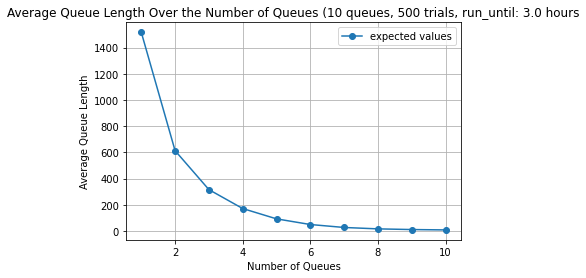

In [ ]:
# Plot the line graph for average queue length with respect to number of queues

plt.plot(x_queues, y_avg_queue_lengths, '-o', label = "expected values")
plt.xlabel('Number of Queues')
plt.ylabel('Average Queue Length')
plt.title(f'Average Queue Length Over the Number of Queues ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours')
plt.grid(True)
plt.legend()
plt.show()

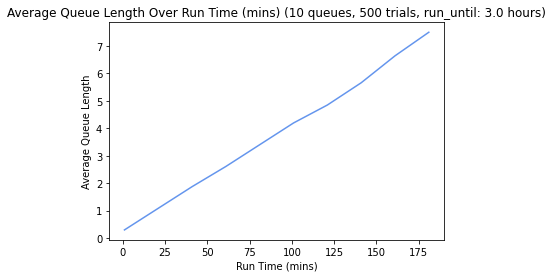

In [ ]:
# Plot the line graph for average queue length with respect to run time

no_of_queues = 10
run_until = 3*60
trials = 500


x_run_times = []
y_avg_queue_lengths_run_time = []
for i in range(1, run_until+21, 20):
    x_run_times.append(i)
    y_avg_queue_lengths_run_time.append(run_airport_experiment_ql(trials, arrival_distribution,
                                                                  service_distribution,
                                                                  additional_screening_distribution,
                                                                  no_of_queues, i))

plt.plot(x_run_times, y_avg_queue_lengths_run_time, color = "cornflowerblue")
plt.xlabel('Run Time (mins)')
plt.ylabel('Average Queue Length')
plt.title(f'Average Queue Length Over Run Time (mins) ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.show()

In [ ]:
# Expected value and 95% confidence interval calculation

# Modify the variables for better run-time and visualization
no_of_queues = 10
run_until = 3*60
trials = 500

average_queue_lengths = []

for i in range(trials):
    airport = run_simulation(arrival_distribution, service_distribution,
                             additional_screening_distribution, no_of_queues, run_until)
    average_queue_lengths.append(average_queue_length(no_of_queues, airport))


mean = round(np.mean(average_queue_lengths), 5)
print(f'Expected value for average queue length for {no_of_queues} queues and {trials} trials:', mean)

t = round(sts.sem(average_queue_lengths), 5)
print(f'Standard error of the average queue length for {no_of_queues} queues and {trials} trials:', t)

conf_interval = [round(mean - 1.96*t, 5), round(mean + 1.96*t, 5)]
print(f'95% confidence interval for the average queue length for {no_of_queues} queues and {trials} trials:',
      conf_interval)

Expected value for average queue length for 10 queues and 500 trials: 7.2564
Standard error of the average queue length for 10 queues and 500 trials: 0.07742
95% confidence interval for the average queue length for 10 queues and 500 trials: [7.10466, 7.40814]


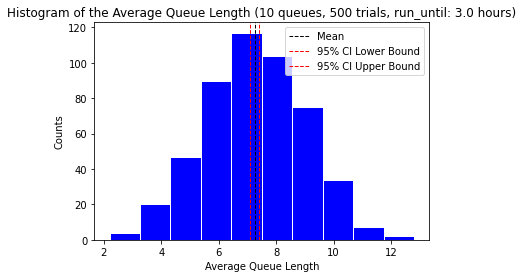

In [ ]:
# Histogram
plt.hist(average_queue_lengths, edgecolor = "white", color = "blue")

# Adding the mean and confidence interval lines
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(conf_interval[0], color='red', linestyle='dashed', linewidth=1, label='95% CI Lower Bound')
plt.axvline(conf_interval[1], color='red', linestyle='dashed', linewidth=1, label='95% CI Upper Bound')

plt.xlabel('Average Queue Length')
plt.ylabel('Counts')
plt.title(f'Histogram of the Average Queue Length ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Error plots with 95% confidence intervals around the expected values

def ql_experiment_error_plots(no_of_trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, no_of_queues, run_until):

    '''
    Conduct a series of experiments to calculate the mean and adjusted standard error
    of the mean (SEM) of the average queue length.

    Returns:
    - tuple: mean result of average queue length and adjusted SEM (95% confidence interval).
    '''

    experiment_results = []
    for i in range(trials):
        airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)
        experiment_results.append(average_queue_length(no_of_queues, airport))

    mean_result = np.mean(experiment_results)
    sem_result = sts.sem(experiment_results)
    sem_result_adjusted = sem_result*1.96 # to show 95% confidence interval around the mean

    return mean_result, sem_result_adjusted

errors = []

for i in range(1, no_of_queues+1):
    _, error = ql_experiment_error_plots(trials, arrival_distribution, service_distribution,
                                         additional_screening_distribution, i, run_until)
    errors.append(error)

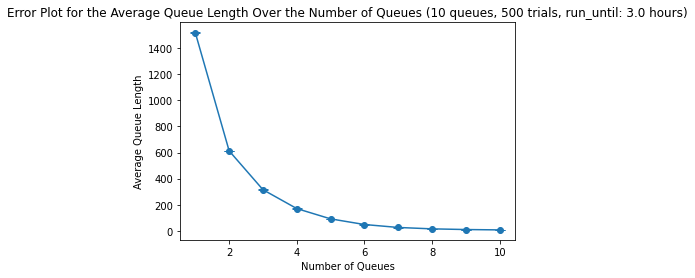

In [ ]:
# Plot with error bars

plt.errorbar(x_queues, y_avg_queue_lengths, yerr=errors, fmt='-o', capsize=5)
plt.xlabel('Number of Queues')
plt.ylabel('Average Queue Length')
plt.title(f'Error Plot for the Average Queue Length Over the Number of Queues ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.show()

## Appendix C.2 -  Average Traveler Waiting Time Given The Number of Service Stations

In [ ]:
# Average waiting time per system calculator

def average_waiting_time(no_of_queues, airport):
    '''
    Calculate the average waiting time for all travelers across all queues in the airport.

    Parameters:
    - no_of_queues (int): Number of queues in the airport.
    - airport (Airport object): Instance of the Airport class representing the current simulation scenario.

    Returns:
    - float: Average waiting time for a traveler across all queues.
    '''

    all_waiting_times = []
    for q in airport.queues:
        # Compute waiting time for each traveler in the queue
        waiting_times_for_queue = [s - e for s, e in zip(q.start_service_times, q.entry_times)]
        all_waiting_times.extend(waiting_times_for_queue)

    # Compute the average waiting time across all queues
    return sum(all_waiting_times) / len(all_waiting_times)



# Set up the experiment function

def run_airport_experiment_wt(trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, no_of_queues, run_until):

    '''
    Run a series of simulation trials and compute the average waiting time across all trials.

    Parameters:
     - trials (int): The number of simulation trials to run.
    .
    .
    .
    .
    - run_until (float): Simulation run time.

    Returns:
    - float: Average waiting time for a traveler over all trials, rounded to 3 decimal places.
    '''

    # For each trial, run the simulation and compute the average waiting time
    experiment_results = []
    for i in range(trials):
        airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)
        experiment_results.append(average_waiting_time(no_of_queues, airport))

    # Calculate and return the average waiting time across all trials
    return round(np.sum(experiment_results) / trials, 3)

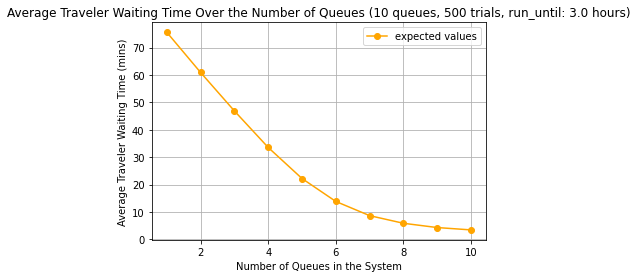

In [ ]:
# Plot the line graph for average waiting time with respect to number of queues

# Modify the variables for better run-time and visualization
no_of_queues = 10
run_until = 3*60
trials = 500

x_queues = []
y_avg_waiting_times = []
for i in range(1, no_of_queues+1):
    x_queues.append(i)
    y_avg_waiting_times.append(run_airport_experiment_wt(trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, i, run_until)) #seconds to minutes

plt.plot(x_queues, y_avg_waiting_times, '-o', label = "expected values", color = "orange")
plt.xlabel('Number of Queues in the System')
plt.ylabel('Average Traveler Waiting Time (mins)')
plt.title(f'Average Traveler Waiting Time Over the Number of Queues ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.grid(True)
plt.legend()
plt.show()

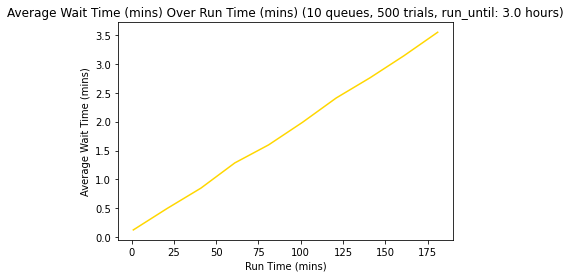

In [ ]:
# Plot the line graph for average wait time with respect to run time

no_of_queues = 10
run_until = 3*60
trials = 500


x_run_times = []
y_avg_wait_times_run_time = []
for i in range(1, run_until+21, 20):
    x_run_times.append(i)
    y_avg_wait_times_run_time.append(run_airport_experiment_wt(trials, arrival_distribution,
                                                               service_distribution,
                                                               additional_screening_distribution,
                                                               no_of_queues, i))

plt.plot(x_run_times, y_avg_wait_times_run_time, color = "gold")
plt.xlabel('Run Time (mins)')
plt.ylabel('Average Wait Time (mins)')
plt.title(f'Average Wait Time (mins) Over Run Time (mins) ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.show()

In [ ]:
# Expected value and 95% confidence interval calculation

# Modify the variables for better run-time and visualization
no_of_queues = 10
run_until = 3*60
trials = 500

average_waiting_times = []

for i in range(trials):
    airport = run_simulation(arrival_distribution, service_distribution,
                             additional_screening_distribution, no_of_queues, run_until)
    average_waiting_times.append(average_waiting_time(no_of_queues, airport))


mean = round(np.mean(average_waiting_times), 5)
print(f'Expected value for average waiting time for {no_of_queues} queues and {trials} trials:', mean, "mins")

t = round(sts.sem(average_waiting_times), 5)
print(f'Standard error of the average waiting time for {no_of_queues} queues and {trials} trials:', t, "mins")

conf_interval = [round(mean - 1.96*t, 5), round(mean + 1.96*t, 5)]
print(f'95% confidence interval for the average queue length for {no_of_queues} queues and {trials} trials:',
      conf_interval)

Expected value for average waiting time for 10 queues and 500 trials: 3.44828 mins
Standard error of the average waiting time for 10 queues and 500 trials: 0.03683 mins
95% confidence interval for the average queue length for 10 queues and 500 trials: [3.37609, 3.52047]


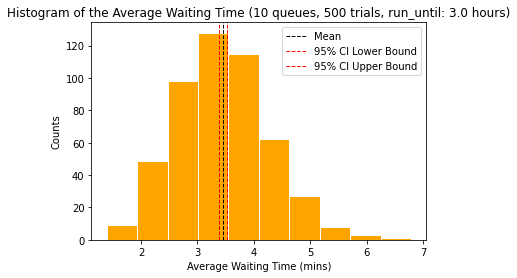

In [ ]:
# Histogram
plt.hist(average_waiting_times, edgecolor = "white", color = "orange")

# Adding the mean and confidence interval lines
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(conf_interval[0], color='red', linestyle='dashed', linewidth=1, label='95% CI Lower Bound')
plt.axvline(conf_interval[1], color='red', linestyle='dashed', linewidth=1, label='95% CI Upper Bound')

plt.xlabel(f'Average Waiting Time (mins)')
plt.ylabel('Counts')
plt.title(f'Histogram of the Average Waiting Time ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Error plots with 95% confidence intervals around the expected values

def wt_experiment_error_plots(no_of_trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, no_of_queues, run_until):

    '''
    Compute the mean and 95% confidence interval for the average waiting time
    from multiple simulation trials.

    Parameters:
    - no_of_trials (int): Number of simulation trials to be run.
    - .
    - .
    - .
    - run_until (float): Simulation run time.

    Returns:
    - tuple: Mean of average waiting times and 95% confidence interval around the mean.

    '''

    experiment_results = []
    for i in range(trials):
        airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)
        experiment_results.append(average_waiting_time(no_of_queues, airport))

    mean_result = np.mean(experiment_results)
    sem_result = sts.sem(experiment_results)
    sem_result_adjusted = sem_result*1.96 # to show 95% confidence interval around the mean

    return mean_result, sem_result_adjusted

errors = []

# Compute error values for the range of number of queues
for i in range(1, no_of_queues+1):
    _, error = wt_experiment_error_plots(trials, arrival_distribution, service_distribution,
                                         additional_screening_distribution, i, run_until)
    errors.append(error)

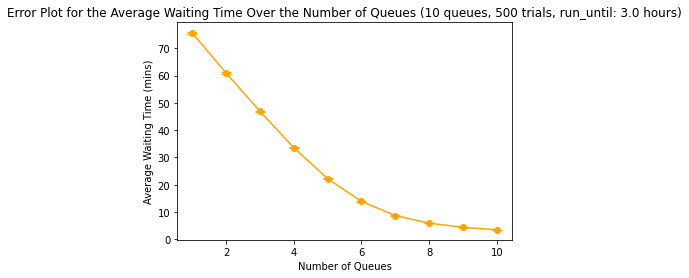

In [ ]:
# Plot with error bars (representing 95% confidence intervals)

plt.errorbar(x_queues, y_avg_waiting_times, yerr=errors, fmt='-o', capsize=5, color = "orange")
plt.xlabel('Number of Queues')
plt.ylabel('Average Waiting Time (mins)')
plt.title(f'Error Plot for the Average Waiting Time Over the Number of Queues ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.show()

## Appendix C.3 - Maximum Queue Length Given The Number of Service Stations

In [ ]:
# Maximum queue length calculator

def maximum_queue_length(no_of_queues, airport):
    '''
    Calculate the maximum queue length observed across all queues in a single simulation.

    Parameters:
    - no_of_queues (int): Number of queues in the airport.
    - airport (Airport object): Instance of an Airport object with its associated queues and states.

    Returns:
    - int: The maximum queue length observed across all queues.
    '''

    # For each queue in the airport, find the maximum length it reached
    all_queue_lengths = []
    for _ in range(no_of_queues):
        all_queue_lengths.append(max(airport.queues[_].length)) #length attribute saves all the lengths of a queue

    # Return the maximum length across all queues
    return max(all_queue_lengths)



# Set up the experiment function

def run_airport_experiment_max_ql(trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, no_of_queues, run_until):
    '''
    Compute the average of the maximum queue length observed across multiple simulation trials.

    Parameters:
    - trials (int): Number of simulation trials to be run.
    - .
    - .
    - .
    - run_until (float): Simulation run time.

    Returns:
    - float: Average of maximum queue lengths observed across all trials.

    '''

    experiment_results = []
    # For each trial, run the simulation and compute the maximum queue length
    for i in range(trials):
        airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)
        experiment_results.append(maximum_queue_length(no_of_queues, airport))

    # Return the average of maximum queue lengths observed across all trials
    return round(np.sum(experiment_results) / trials, 3)

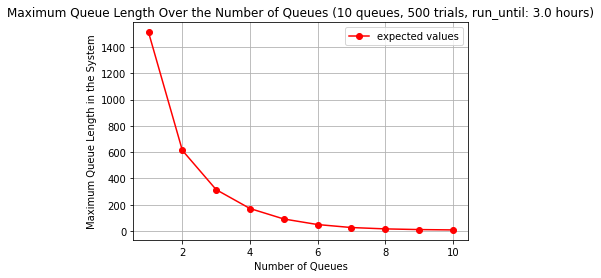

In [ ]:
no_of_queues = 10
run_until = 3*60
trials = 500


x_queues = []
y_max_queue_lengths = []
for i in range(1, no_of_queues+1):
    x_queues.append(i)
    y_max_queue_lengths.append(run_airport_experiment_max_ql(trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, i, run_until))

plt.plot(x_queues, y_max_queue_lengths, '-o', label = "expected values", color = "red")
plt.xlabel('Number of Queues')
plt.ylabel('Maximum Queue Length in the System')
plt.title(f'Maximum Queue Length Over the Number of Queues ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Expected value and 95% confidence interval calculation

# Modify the variables for better run-time and visualization
no_of_queues = 10
run_until = 3*60
trials = 500

max_queue_lengths = []

for i in range(trials):
    airport = run_simulation(arrival_distribution, service_distribution,
                             additional_screening_distribution, no_of_queues, run_until)
    max_queue_lengths.append(maximum_queue_length(no_of_queues, airport))


mean = round(np.mean(max_queue_lengths), 5)
print(f'Expected value for maximum queue length for {no_of_queues} queues and {trials} trials:', mean)

t = round(sts.sem(max_queue_lengths), 5)
print(f'Standard error of the maximum queue length for {no_of_queues} queues and {trials} trials:', t)

conf_interval = [round(mean - 1.96*t, 5), round(mean + 1.96*t, 5)]
print(f'95% confidence interval for the maximum queue length for {no_of_queues} queues and {trials} trials:',
      conf_interval)

Expected value for maximum queue length for 10 queues and 500 trials: 8.598
Standard error of the maximum queue length for 10 queues and 500 trials: 0.06959
95% confidence interval for the maximum queue length for 10 queues and 500 trials: [8.4616, 8.7344]


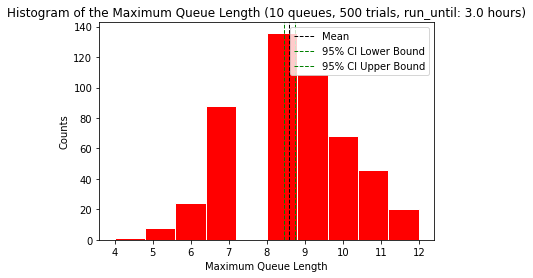

In [ ]:
# Histogram
plt.hist(max_queue_lengths, edgecolor = "white", color = "red")

# Adding the mean and confidence interval lines
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(conf_interval[0], color='green', linestyle='dashed', linewidth=1, label='95% CI Lower Bound')
plt.axvline(conf_interval[1], color='green', linestyle='dashed', linewidth=1, label='95% CI Upper Bound')

plt.xlabel('Maximum Queue Length')
plt.ylabel('Counts')
plt.title(f'Histogram of the Maximum Queue Length ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Error plots with 95% confidence intervals around the expected values

def max_ql_experiment_error_plots(no_of_trials, arrival_distribution, service_distribution,
                              additional_screening_distribution, no_of_queues, run_until):

    '''
    Compute the mean and 95% confidence interval for the maximum queue length
    from multiple simulation trials.

    Parameters:
    - no_of_trials (int): Number of simulation trials to be run.
    - .
    - .
    - .
    - run_until (float): Simulation run time.

    Returns:
    - tuple: Mean of maximum queue lengths and 95% confidence interval around the mean.

    '''

    experiment_results = []
    for i in range(trials):
        airport = run_simulation(arrival_distribution, service_distribution,
                         additional_screening_distribution, no_of_queues, run_until)
        experiment_results.append(maximum_queue_length(no_of_queues, airport))

    mean_result = np.mean(experiment_results)
    sem_result = sts.sem(experiment_results)
    sem_result_adjusted = sem_result*1.96 # to show 95% confidence interval around the mean

    return mean_result, sem_result_adjusted

errors = []

# Compute error values for the range of number of queues
for i in range(1, no_of_queues+1):
    _, error = max_ql_experiment_error_plots(trials, arrival_distribution, service_distribution,
                                         additional_screening_distribution, i, run_until)
    errors.append(error)

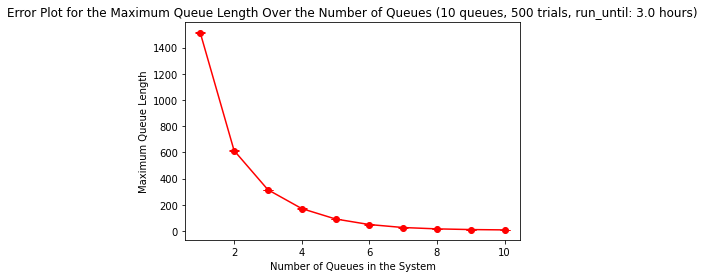

In [ ]:
# Plot with error bars (representing 95% confidence intervals)

plt.errorbar(x_queues, y_max_queue_lengths, yerr=errors, fmt='-o', capsize=5, color = "red")
plt.xlabel('Number of Queues in the System')
plt.ylabel('Maximum Queue Length')
plt.title(f'Error Plot for the Maximum Queue Length Over the Number of Queues ({no_of_queues} queues, {trials} trials, run_until: {run_until/60} hours)')
plt.show()

# Appendix D - Conclusion and Suggestions

### Appendix D.1 - Average Queue Length

In [ ]:
# Modify the variables for better run-time and visualization
no_of_queues = 7
run_until = 3*60
trials = 500

average_queue_lengths = []

for i in range(trials):
    airport = run_simulation(arrival_distribution, service_distribution,
                             additional_screening_distribution, no_of_queues, run_until)
    average_queue_lengths.append(average_queue_length(no_of_queues, airport))


mean = round(np.mean(average_queue_lengths), 5)
print(f'Expected value for average queue length for {no_of_queues} queues and {trials} trials:', mean)

t = round(sts.sem(average_queue_lengths), 5)
print(f'Standard error of the average queue length for {no_of_queues} queues and {trials} trials:', t)

conf_interval = [round(mean - 1.96*t, 5), round(mean + 1.96*t, 5)]
print(f'95% confidence interval for the average queue length for {no_of_queues} queues and {trials} trials:',
      conf_interval)

Expected value for average queue length for 7 queues and 500 trials: 25.93943
Standard error of the average queue length for 7 queues and 500 trials: 0.2105
95% confidence interval for the average queue length for 7 queues and 500 trials: [25.52685, 26.35201]


### Appendix D.2 - Average Waiting Time

In [ ]:
# Modify the variables for better run-time and visualization
no_of_queues = 7
run_until = 3*60
trials = 500

average_waiting_times = []

for i in range(trials):
    airport = run_simulation(arrival_distribution, service_distribution,
                             additional_screening_distribution, no_of_queues, run_until)
    average_waiting_times.append(average_waiting_time(no_of_queues, airport))


mean = round(np.mean(average_waiting_times), 5)
print(f'Expected value for average waiting time for {no_of_queues} queues and {trials} trials:', mean, "mins")

t = round(sts.sem(average_waiting_times), 5)
print(f'Standard error of the average waiting time for {no_of_queues} queues and {trials} trials:', t, "mins")

conf_interval = [round(mean - 1.96*t, 5), round(mean + 1.96*t, 5)]
print(f'95% confidence interval for the average queue length for {no_of_queues} queues and {trials} trials:',
      conf_interval)

Expected value for average waiting time for 7 queues and 500 trials: 8.77855 mins
Standard error of the average waiting time for 7 queues and 500 trials: 0.08665 mins
95% confidence interval for the average queue length for 7 queues and 500 trials: [8.60872, 8.94838]


### Appendix D.3 - Maximum Queue Length

In [ ]:
# Modify the variables for better run-time and visualization
no_of_queues = 7
run_until = 3*60
trials = 500

max_queue_lengths = []

for i in range(trials):
    airport = run_simulation(arrival_distribution, service_distribution,
                             additional_screening_distribution, no_of_queues, run_until)
    max_queue_lengths.append(maximum_queue_length(no_of_queues, airport))


mean = round(np.mean(max_queue_lengths), 5)
print(f'Expected value for maximum queue length for {no_of_queues} queues and {trials} trials:', mean)

t = round(sts.sem(max_queue_lengths), 5)
print(f'Standard error of the maximum queue length for {no_of_queues} queues and {trials} trials:', t)

conf_interval = [round(mean - 1.96*t, 5), round(mean + 1.96*t, 5)]
print(f'95% confidence interval for the maximum queue length for {no_of_queues} queues and {trials} trials:',
      conf_interval)

Expected value for maximum queue length for 7 queues and 500 trials: 27.442
Standard error of the maximum queue length for 7 queues and 500 trials: 0.21632
95% confidence interval for the maximum queue length for 7 queues and 500 trials: [27.01801, 27.86599]
